In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
import tensorflow.keras as ks
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import image_data_format
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization, MaxPooling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape

img_size = (299, 299)
input_shape = (299, 299, 3)
batch_size = 32
extract_path_train="/kaggle/input/cats-and-dogs/cats-and-dogs/train"
extract_path_validation="/kaggle/input/cats-and-dogs/cats-and-dogs/validation"
WEIGHTS_PATH = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory( 
    extract_path_train, 
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='binary'
) 
val_generator = validation_datagen.flow_from_directory( 
    extract_path_validation, 
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle = False
) 

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [10]:
def inception_module_a(x, filters, concat_axis, name):

  block1x1 = conv_bn(x, 64, (1, 1), name=f"{name}_block1x1")

  block_pool = AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
  block_pool = conv_bn(block_pool, filters, (1, 1), name=f"{name}_block_pool")

  block3x3 = conv_bn(x, 64, (1, 1), name=f"{name}_block3x3_1")
  block3x3 = conv_bn(block3x3, 96, (3, 3), name=f"{name}_block3x3_2")
  block3x3 = conv_bn(block3x3, 96, (3,3), name=f"{name}_block3x3_3")

  block5x5 = conv_bn(x, 48, (1, 1), name=f"{name}_block5x5_1")
  block5x5 = conv_bn(block5x5, 64, (5, 5), name=f"{name}_block5x5_2")


  x = Concatenate(axis=concat_axis, name=f"{name}_mixed")([block1x1, block5x5, block3x3, block_pool])

  return x

In [11]:
def inception_module_b(x, filters, concat_axis, name):
  block1x1 = conv_bn(x, 192, (1, 1), name=f"{name}_block1x1")

  block_pool = AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
  block_pool = conv_bn(block_pool, 192, (1, 1), name=f"{name}_block_pool")

  block7x7 = conv_bn(x, filters, (1, 1), name=f"{name}_block7x7_1")
  block7x7 = conv_bn(block7x7, filters, (1, 7), name=f"{name}_block7x7_2")
  block7x7 = conv_bn(block7x7, 192, (7, 1), name=f"{name}_block7x7_3")

  block7x7d = conv_bn(x, filters, (1, 1), name=f"{name}_block7x7d_1")
  block7x7d = conv_bn(block7x7d, filters, (7, 1), name=f"{name}_block7x7d_2")
  block7x7d = conv_bn(block7x7d, filters, (1, 7), name=f"{name}_block7x7d_3")
  block7x7d = conv_bn(block7x7d, filters, (7, 1), name=f"{name}_block7x7d_4")
  block7x7d = conv_bn(block7x7d, 192, (1, 7), name=f"{name}_block7x7d_5")

  x = Concatenate(axis=concat_axis, name=f"{name}_mixed")([block1x1, block7x7, block7x7d, block_pool])

  return x

In [12]:
def inception_module_c(x, concat_axis, name):
  block1x1 = conv_bn(x, 320, (1, 1), name=f"{name}_block1x1")

  block_pool = AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
  block_pool = conv_bn(block_pool, 192, (1, 1), name=f"{name}_block_pool")

  block3x3 = conv_bn(x, 384, (1, 1), name=f"{name}_block3x3")
  block3x3_1 = conv_bn(block3x3, 384, (1, 3), name=f"{name}_block3x3_1")
  block3x3_2 = conv_bn(block3x3, 384, (3, 1), name=f"{name}_block3x3_2")

  block3x3 = Concatenate(axis=concat_axis, name=f"{name}_mixed_block3x3")([block3x3_1, block3x3_2])

  block3x3d = conv_bn(x, 448, (1, 1), name=f"{name}_block3x3d")
  block3x3d = conv_bn(block3x3d, 384, (3, 3), name=f"{name}_block3x3d_1")
  block3x3d_1 = conv_bn(block3x3d, 384, (1, 3), name=f"{name}_block3x3d_2")
  block3x3d_2 = conv_bn(block3x3d, 384, (3, 1), name=f"{name}_block3x3d_3")

  block3x3d = Concatenate(axis=concat_axis, name=f"{name}_mixed_block3x3d")([block3x3d_1, block3x3d_2])

  x = Concatenate(axis=concat_axis, name=f"{name}_mixed_block")([block1x1, block3x3, block3x3d, block_pool])

  return x

In [13]:
def conv_bn(x, filters, kernel_size, strides=(1, 1), padding="same", name=None):
  
  if image_data_format() == "channels_first":
    bn_axis = 1
  else:
    bn_axis = 3

  x = Conv2D(filters, kernel_size=kernel_size, use_bias=False, strides=strides, padding=padding, name=f"{name}_conv_2d")(x)
  x = BatchNormalization(axis=bn_axis, scale=False)(x)
  x = Activation("relu")(x)

  return x

In [14]:
def load_weights(model,weights,include_top):
    if weights == 'imagenet':
        if include_top:
            weights_path = ks.utils.get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='9a0d58056eeedaa3f26cb7ebd46da564')
        else:
            weights_path = ks.utils.get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='bcbd6486424b2319ff4ef7d526e38f63')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)
    
    return model

In [15]:
def classifier(x, num_clasees):
  x = AveragePooling2D((5, 5), strides=(3, 3))(x)
  x = conv_bn(x, 128, 1, 1, name="classifier")
  x = Dense(num_clasees, activation="softmax", name="classifier")(x)
  return x

In [16]:
def inception_v3(include_top=True, num_classes=1000, weights="imagenet", input_tensor=None, input_shape=None, pooling=None, **kwargs):

  input_shape = _obtain_input_shape(input_shape, default_size=299, min_size=75, data_format=image_data_format(), require_flatten=include_top, weights=weights)

  if input_tensor is None:
    img_input = Input(shape=input_shape)
  else:
    if not backend.is_keras_tensor(input_tensor):
      img_input = Input(tensor=input_tensor, shape=input_shape)
    
    else:
      img_input = input_tensor
  
  if image_data_format() == "channels_first":
    channel_axis = 1  
  else:
    channel_axis = 3

  x = conv_bn(img_input, 32, kernel_size=(3, 3), strides=(2,2), padding="valid", name="conv_bn_1")
  x = conv_bn(x, 32, kernel_size=(3, 3), name="conv_bn_2")
  x = conv_bn(x, 64, kernel_size=(3, 3), name="conv_bn_3")

  x = MaxPooling2D((3,3), strides=(2, 2))(x)

  x = conv_bn(x, 80, kernel_size=(1, 1), padding="valid", name="conv_bn_4")
  x = conv_bn(x, 192, kernel_size=(3, 3), padding="valid", name="conv_bn_5")

  x = MaxPooling2D((3,3), strides=(2, 2))(x)
  
  x = inception_module_a(x, 32, channel_axis, "A0") # mixed 0: 35 x 35 x 256
  x = inception_module_a(x, 64, channel_axis, "A1") # mixed 1: 35 x 35 x 288
  x = inception_module_a(x, 64, channel_axis, "A2") # mixed 2: 35 x 35 x 288

  branch3x3 = conv_bn(x, 384, (3, 3), strides=(2, 2), padding='valid', name="conv_bn_6")

  branch3x3dbl = conv_bn(x, 64, (1, 1), name="conv_bn_7")
  branch3x3dbl = conv_bn(branch3x3dbl, 96, (3, 3), name="conv_bn_8")
  branch3x3dbl = conv_bn(branch3x3dbl, 96, (3, 3), strides=(2, 2), padding='valid', name="conv_bn_9")

  branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
  x = Concatenate(axis=channel_axis, name='mixed3')([branch3x3, branch3x3dbl, branch_pool])
  
  x = inception_module_b(x,128,channel_axis,"B4") # mixed 4: 17 x 17 x 768
  x = inception_module_b(x,160,channel_axis,"B5")
  x = inception_module_b(x,160,channel_axis,"B6")
  x = inception_module_b(x,192,channel_axis,"B7")

  x1 = classifier(x,num_classes)

  branch3x3 = conv_bn(x, 192, (1, 1), name="conv_bn_10")
  branch3x3 = conv_bn(branch3x3, 320, (3, 3), strides=(2, 2), padding='valid', name="conv_bn_11")

  branch7x7x3 = conv_bn(x, 192, (1, 1), name="conv_bn_12")
  branch7x7x3 = conv_bn(branch7x7x3, 192, (1, 7), name="conv_bn_13")
  branch7x7x3 = conv_bn(branch7x7x3, 192, (7, 1), name="conv_bn_14")
  branch7x7x3 = conv_bn(branch7x7x3, 192, (3, 3), strides=(2, 2), padding='valid', name="conv_bn_15")

  branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
  x = Concatenate(axis=channel_axis, name='mixed8')([branch3x3, branch7x7x3, branch_pool])

  x = inception_module_c(x,channel_axis,"C1")
  x = inception_module_c(x,channel_axis,"C2")

  if include_top:
      x = GlobalAveragePooling2D(name='avg_pool')(x)
      x = Dense(num_classes, activation='softmax', name='predictions')(x)
  else:
      if pooling == 'avg':
          x = GlobalAveragePooling2D()(x)
      elif pooling == 'max':
          x = GlobalMaxPooling2D()(x)
  
  if input_tensor is not None:
      inputs = ks.keras_utils.get_source_inputs(input_tensor)
  else:
      inputs = img_input

  model = Model(inputs, x, name='inception_v3')
  
  model = load_weights(model,weights,include_top)
  print("Inception v3 model created")
  model._name = "Inception_V3"
  return model

In [17]:
base_model = inception_v3(include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

x = base_model.output
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1762979437.194290      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762979437.194958      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Inception v3 model created


In [18]:
history = model.fit( 
    train_generator, 
    steps_per_epoch=train_generator.samples//batch_size, 
    epochs=30, 
    validation_data=val_generator, 
    validation_steps=val_generator.samples//batch_size, 
    validation_freq=1
) 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1762979451.072027     152 service.cc:148] XLA service 0x79307c058dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762979451.072720     152 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762979451.072744     152 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762979453.245225     152 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/18 ━━━━━━━━━━━━━━━━━━━━ 5:57 21s/step - accuracy: 0.4688 - loss: 0.7893

I0000 00:00:1762979463.660951     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6278 - loss: 0.6400 - val_accuracy: 0.9688 - val_loss: 0.2874
Epoch 2/30
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.7812 - loss: 0.4421

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7812 - loss: 0.4421 - val_accuracy: 0.9688 - val_loss: 0.2740
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 715ms/step - accuracy: 0.9175 - loss: 0.2841 - val_accuracy: 0.9688 - val_loss: 0.1471
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9688 - loss: 0.2017 - val_accuracy: 0.9688 - val_loss: 0.1432
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 732ms/step - accuracy: 0.9476 - loss: 0.1930 - val_accuracy: 0.9792 - val_loss: 0.1055
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9688 - loss: 0.1311 - val_accuracy: 0.9688 - val_loss: 0.1049
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 728ms/step - accuracy: 0.9689 - loss: 0.1424 - val_accuracy: 0.9792 - val_loss: 0.0839
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 1.0000 - loss: 0.0825 - val_accuracy: 0.9688 - val_loss: 0.0840
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 732ms/step - accuracy: 0.9622 - loss: 0.1491 - val_accuracy: 0.9792 - val_

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9847 - loss: 0.0397  


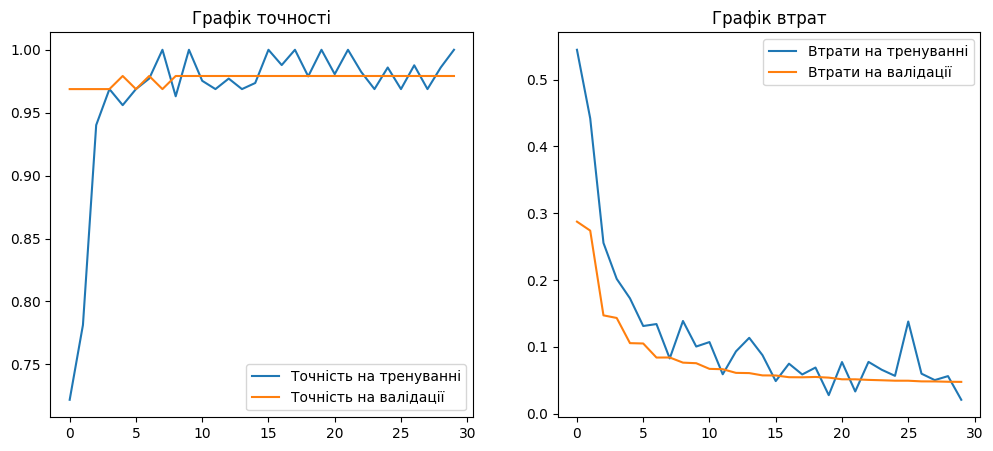

In [19]:
loss, accuracy = model.evaluate(val_generator)

import matplotlib.pyplot as plt 
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs_range = range(len(acc))
plt.figure(figsize=(12, 5)) 
plt.subplot(1, 2, 1) 
plt.plot(epochs_range, acc, label='Точність на тренуванні')
plt.plot(epochs_range, val_acc, label='Точність на валідації') 
plt.legend() 
plt.title('Графік точності') 
plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Втрати на тренуванні') 
plt.plot(epochs_range, val_loss, label='Втрати на валідації') 
plt.legend() 
plt.title('Графік втрат') 
plt.show() 

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step 
Accuracy = 0.98
Precision = 0.98
Recall = 0.98
F-Score = 0.98


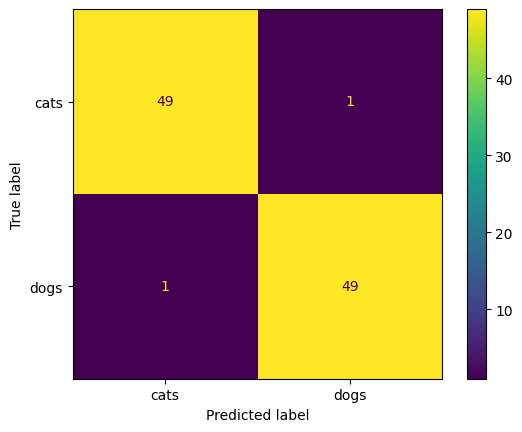

In [20]:
from sklearn import metrics

class_names = list(train_generator.class_indices.keys())
y_pred_probs = model.predict(val_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = val_generator.classes

cm = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)

print(f"Accuracy = {metrics.accuracy_score(y_true, y_pred)}")
print(f"Precision = {metrics.precision_score(y_true, y_pred, average='weighted')}")
print(f"Recall = {metrics.recall_score(y_true, y_pred, average='weighted')}")
print(f"F-Score = {metrics.f1_score(y_true, y_pred, average='weighted')}")

cm_display.plot()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


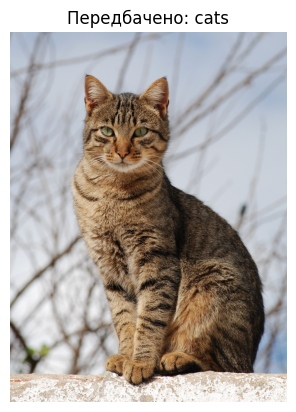

In [21]:
from PIL import Image, ImageOps
import matplotlib.image as mpimg
import os
import random

def recognize_animal(image_path, model, class_names_list):
    plt.imshow(mpimg.imread(image_path))
    img = Image.open(image_path).convert('RGB')
    img = img.resize((227, 227))
    img_array = np.array(img).astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_animal = class_names_list[predicted_index]
    plt.title(f"Передбачено: {predicted_animal}")
    plt.axis('off')
    plt.show()

recognize_animal('/kaggle/input/animals/Cat_November.jpg', model, class_names)